In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import random
from scipy import stats

In [3]:
import datetime as dt
from datetime import datetime
import matplotlib.dates as mdates

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

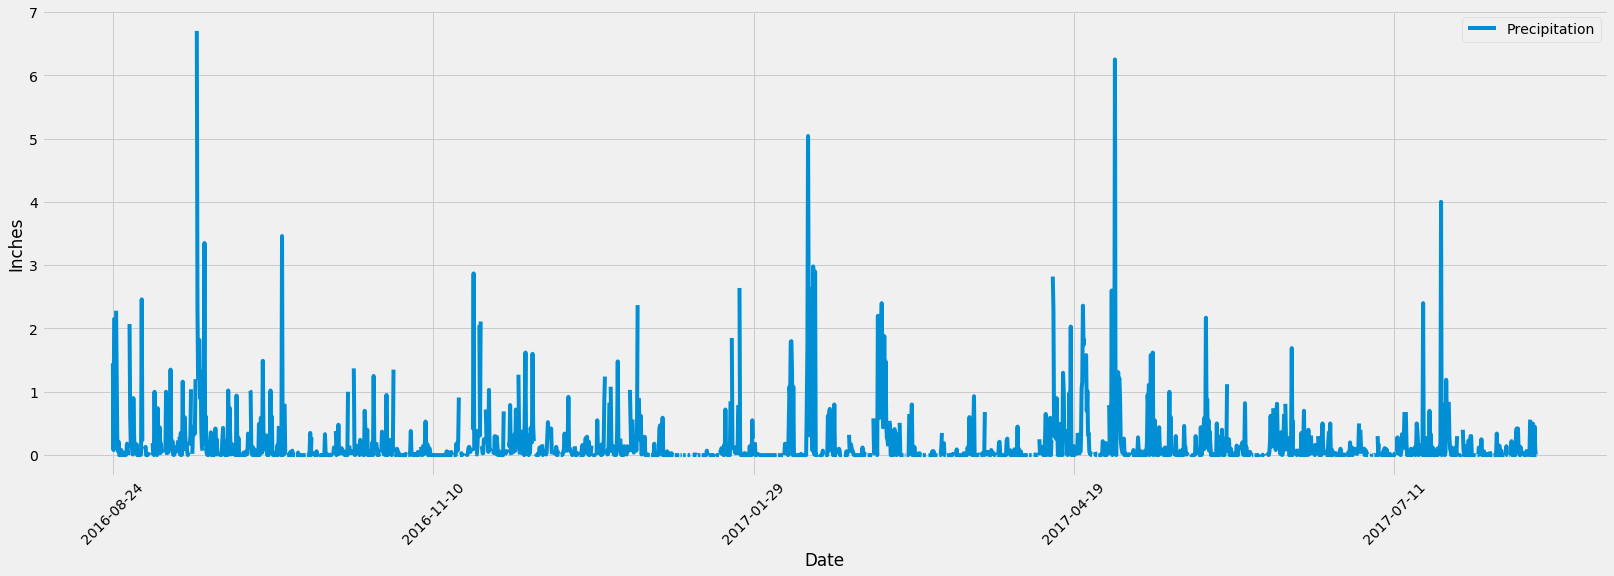

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

for date in latest_date:
    latest_date_dict = {}
    latest_date_dict["date"] = date

latest_date_fixed = datetime.strptime(latest_date_dict.get("date"), "%Y-%m-%d")
beginning_date = latest_date_fixed - dt.timedelta(days = 365)
beginning_date

# Perform a query to retrieve the data and precipitation scores
last_year = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > beginning_date).\
    order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_df = pd.DataFrame(last_year)
last_year_df.rename(columns = {"date":"Date", "prcp":"Precipitation"}, inplace = True)
last_year_df = last_year_df.set_index("Date")

# Sort the dataframe by date
last_year_df = last_year_df.sort_values("Date")

# Use Pandas Plotting with Matplotlib to plot the data

last_year_df = last_year_df.reset_index()
ax = last_year_df.plot(x = "Date", y = "Precipitation", kind = "line", figsize = (25,8), rot = 45, grid = True)
ax.set_ylabel("Inches")
ax.set_xlabel("Date")
plt.show()



In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
all_data = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).all()
all_data_summary = pd.DataFrame(all_data).describe()
all_data_summary


id          prcp          tobs
count  19550.000000  18103.000000  19550.000000
mean    9775.500000      0.160644     73.097954
std     5643.743217      0.468746      4.523527
min        1.000000      0.000000     53.000000
25%     4888.250000      0.000000     70.000000
50%     9775.500000      0.010000     73.000000
75%    14662.750000      0.110000     76.000000
max    19550.000000     11.530000     87.000000

In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct().count()


9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_list = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).\
    all()
station_list


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
new_station_list = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).\
    all()

most_active = new_station_list[0]

for station in most_active:
    most_active_dict = {}
    most_active_dict["station"] = station

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_dict.get("station")).all()

[(54.0, 85.0, 71.66378066378067)]

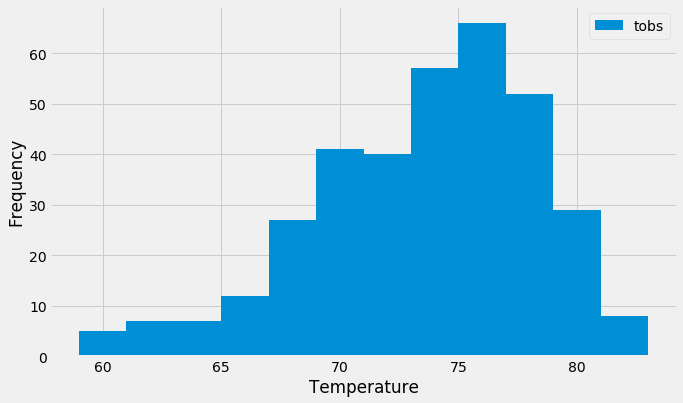

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_year = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_dict.get("station")).\
    filter(Measurement.date > beginning_date).\
    order_by(Measurement.date).all()

temp_year_df = pd.DataFrame(temp_year)
temp_year_df.rename(columns = {"date":"Date", "tobs": "Temperature"}, inplace = True)

ax = temp_year_df.hist(column = "Temperature", bins = 12, grid = True, figsize = (10,6))
plt.title("")
plt.legend(["tobs"])
ax = ax[0]

for x in ax:
    x.set_ylabel("Frequency")
    x.set_xlabel("Temperature")

plt.show()


## Bonus Challenge Assignment

In [16]:
#Paired t-test challenge

# Find means and standard deviations
june_temps = session.query(Measurement.tobs).\
    filter(func.strftime("%m", Measurement.date) == "06").all()

dec_temps = session.query(Measurement.tobs).\
    filter(func.strftime("%m", Measurement.date) == "12").all()

june_temps_df = pd.DataFrame(june_temps)
dec_temps_df = pd.DataFrame(dec_temps)

june_temps_mean = june_temps_df["tobs"].mean()
dec_temps_mean = dec_temps_df["tobs"].mean()

june_temps_std = june_temps_df["tobs"].std()
dec_temps_std = dec_temps_df["tobs"].std()

# Take samples 
random.seed(20)

sample_size = 30 #number of samples to take from each population
june_sample = [random.gauss(june_temps_mean, june_temps_std) for x in range(sample_size)]
dec_sample = [random.gauss(dec_temps_mean, dec_temps_std) for x in range(sample_size)]

#Calculate P-Value and T-Statistic
t_stat, p_value =  stats.ttest_rel(june_sample, dec_sample)

print(f"The June mean is {june_temps_mean}.\nThe December mean is {dec_temps_mean}.\nThe June standard deviation is {june_temps_std}.\nThe December standard deviation is {dec_temps_std}.")
print("\n")
print("P-Value:{0} T-Statistic:{1}".format(p_value,t_stat))
print("\n")
print("Because the P-Value is so low, I can reject the null hypothesis \nthat the June and December mean temperatures are equal, and show \ninstead that there is a statistical difference between the two datasets.")
print("\n")
print("I chose to use a paired t-test because I am examining two datasets \nfrom the same population of weather stations, separated by time.")


The June mean is 74.94411764705882.
The December mean is 71.04152933421226.
The June standard deviation is 3.2574170516565566.
The December standard deviation is 3.745919825315848.


P-Value:0.0002669272205500647 T-Statistic:4.148506847654567


Because the P-Value is so low, I can reject the null hypothesis 
that the June and December mean temperatures are equal, and show 
instead that there is a statistical difference between the two datasets.


I chose to use a paired t-test because I am examining two datasets 
from the same population of weather stations, separated by time.


In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_temps("2016-07-15", "2016-08-01")


[(71.0, 77.68867924528301, 83.0)]

Text(0, 0.5, 'Temperature')

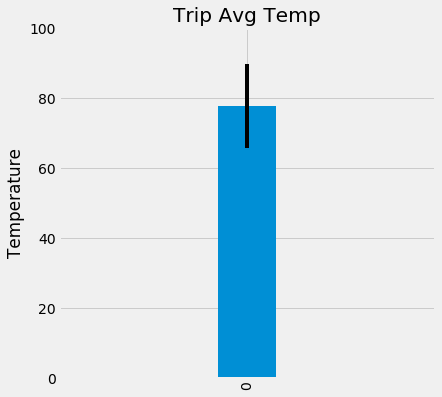

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_data = calc_temps("2016-07-15", "2016-08-01")

trip_datapoints = []
for min, avg, max in trip_data:
    trip_data_dict = {}
    trip_data_dict["Min Temp"] = min
    trip_data_dict["Avg Temp"] = avg
    trip_data_dict["Max Temp"] = max
    trip_datapoints.append(trip_data_dict)
    
trip_data_df = pd.DataFrame(trip_datapoints)
trip_data_df

peak_to_peak = trip_data_df["Max Temp"] - trip_data_df["Min Temp"]
ax = trip_data_df[("Avg Temp")].plot(kind = "bar", figsize = (6,6), width = .09, yerr = peak_to_peak)
ax.set_ylim(0,100)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature")


In [52]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
hist_rain = session.query(Measurement.station, Measurement.prcp, Station.name, Station.latitude, Station.longitude, Station.elevation).\
    filter(Measurement.date >= "2016-07-15").\
    filter(Measurement.date <= "2016-08-01").\
    filter(Measurement.station == Station.station).\
    order_by(desc(Measurement.prcp)).all()

hist_rain_data = []
for station, precipitation, name, latitude, longitude, elevation in hist_rain:
    hist_rain_dict = {}
    hist_rain_dict["Station ID"] = station
    hist_rain_dict["Precipitation"] = precipitation
    hist_rain_dict["Station Name"] = name
    hist_rain_dict["Latitude"] = latitude
    hist_rain_dict["Longitude"] = longitude
    hist_rain_dict["Elevation"] = elevation
    hist_rain_data.append(hist_rain_dict)
    
hist_rain_df = pd.DataFrame(hist_rain_data)
hist_rain_df = hist_rain_df[["Station ID", "Station Name", "Latitude", "Longitude", "Elevation", "Precipitation"]].dropna()

hist_rain_df


Station ID                        Station Name  Latitude  Longitude  \
0   USC00519281                 WAIHEE 837.5, HI US  21.45167 -157.84889   
1   USC00513117                KANEOHE 838.1, HI US  21.42340 -157.80150   
2   USC00516128        MANOA LYON ARBO 785.2, HI US  21.33310 -157.80250   
3   USC00519397                WAIKIKI 717.2, HI US  21.27160 -157.81680   
4   USC00519281                 WAIHEE 837.5, HI US  21.45167 -157.84889   
..          ...                                 ...       ...        ...   
90  USC00519523  WAIMANALO EXPERIMENTAL FARM, HI US  21.33556 -157.71139   
91  USC00519523  WAIMANALO EXPERIMENTAL FARM, HI US  21.33556 -157.71139   
92  USC00519281                 WAIHEE 837.5, HI US  21.45167 -157.84889   
93  USC00519281                 WAIHEE 837.5, HI US  21.45167 -157.84889   
94  USC00516128        MANOA LYON ARBO 785.2, HI US  21.33310 -157.80250   

    Elevation  Precipitation  
0        32.9           9.64  
1        14.6           7.65  
2       152.4           5.35  
3         3.0           4.20  
4        32.9           3.53  
..        ...            ...  
90       19.5           0.00  
91       19.5           0.00  
92       32.9           0.00  
93       32.9           0.00  
94      152.4           0.00  

[95 rows x 6 columns]

In [40]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [44]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
first_trip_date = datetime.strptime("2016-07-15", "%Y-%m-%d")
last_trip_date = datetime.strptime("2016-08-01", "%Y-%m-%d")

delta = dt.timedelta(days=1)

trip_dates = []
while first_trip_date <= last_trip_date:
    trip_dates.append(first_trip_date)
    first_trip_date += delta

converted_dates = []
for date in trip_dates:
    converted_date = date.strftime("%m-%d")
    converted_dates.append(converted_date)

daily_normals_data =[]
for date in converted_dates:
    daily_normals_datapoint = session.query(*sel).\
        filter(func.strftime("%m-%d", Measurement.date) == date).all()
    daily_normals_data.append(daily_normals_datapoint)

daily_normals_data


[[(68.0, 76.2542372881356, 82.0)],
 [(70.0, 76.34482758620689, 83.0)],
 [(70.0, 76.30188679245283, 83.0)],
 [(72.0, 76.63793103448276, 83.0)],
 [(68.0, 75.89090909090909, 83.0)],
 [(69.0, 75.46296296296296, 82.0)],
 [(69.0, 76.9245283018868, 83.0)],
 [(69.0, 75.78846153846153, 81.0)],
 [(70.0, 76.20370370370371, 84.0)],
 [(69.0, 76.55555555555556, 81.0)],
 [(67.0, 76.89090909090909, 84.0)],
 [(71.0, 76.4423076923077, 86.0)],
 [(68.0, 76.58181818181818, 83.0)],
 [(69.0, 76.46428571428571, 82.0)],
 [(69.0, 76.47058823529412, 83.0)],
 [(69.0, 77.35185185185185, 84.0)],
 [(72.0, 77.03571428571429, 83.0)],
 [(67.0, 75.54, 83.0)]]

In [94]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_fixed_list = [item for sublist in daily_normals_data for item in sublist]

daily_normals_new_list = []
for (min, avg, max) in daily_normals_fixed_list:
    daily_normals_dict = {}
    daily_normals_dict["Min Temp"] = min
    daily_normals_dict["Avg Temp"] = avg
    daily_normals_dict["Max Temp"] = max
    daily_normals_new_list.append(daily_normals_dict)

new_converted_dates = []
for date in trip_dates:
    new_converted_date = date.strftime("%Y-%m-%d")
    new_converted_dates.append(new_converted_date)

daily_normals_df = pd.DataFrame(daily_normals_new_list)
daily_normals_df.insert(1, "Dates", new_converted_dates, True)
daily_normals_df.set_index("Dates", inplace = True)

daily_normals_df


Min Temp   Avg Temp  Max Temp
Dates                                    
2016-07-15      68.0  76.254237      82.0
2016-07-16      70.0  76.344828      83.0
2016-07-17      70.0  76.301887      83.0
2016-07-18      72.0  76.637931      83.0
2016-07-19      68.0  75.890909      83.0
2016-07-20      69.0  75.462963      82.0
2016-07-21      69.0  76.924528      83.0
2016-07-22      69.0  75.788462      81.0
2016-07-23      70.0  76.203704      84.0
2016-07-24      69.0  76.555556      81.0
2016-07-25      67.0  76.890909      84.0
2016-07-26      71.0  76.442308      86.0
2016-07-27      68.0  76.581818      83.0
2016-07-28      69.0  76.464286      82.0
2016-07-29      69.0  76.470588      83.0
2016-07-30      69.0  77.351852      84.0
2016-07-31      72.0  77.035714      83.0
2016-08-01      67.0  75.540000      83.0

Text(0, 0.5, 'Temperature')

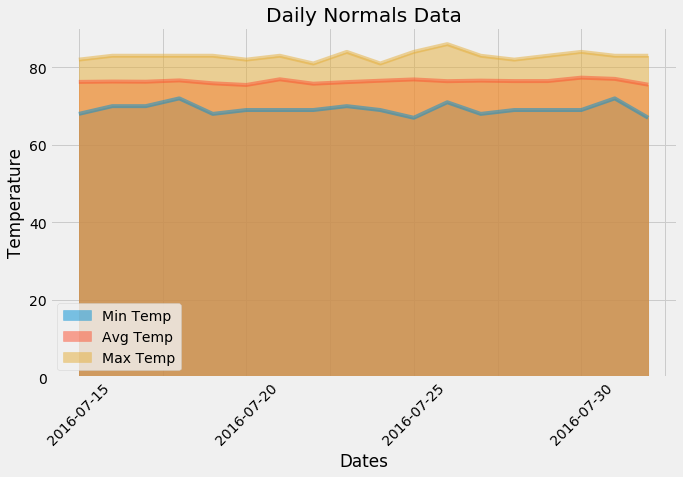

In [96]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot(kind = "area", stacked = False, figsize = (10,6), rot = 45)
plt.title("Daily Normals Data")
plt.ylabel("Temperature")
